In [228]:
# Import libraries
import pandas as pd
import os
import numpy as np
import random
from datetime import datetime as dt
import statistics as st
from scipy.stats import shapiro, kruskal

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from kneed import KneeLocator 
from sklearn.manifold import TSNE

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [189]:
# Import and read the dataset
df = pd.read_csv("2A.tsv", sep = "\t")
df

,Customer ID,Birth Date,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,1969/03/05,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,2005/07/01,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,1974/12/01,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,2003/11/21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,1979/09/13,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3896,1984/02/23,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,Cash,2-Day Shipping,No,No,32,Venmo,Weekly
3896,3897,1972/02/11,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,PayPal,Store Pickup,No,No,41,Bank Transfer,Bi-Weekly
3897,3898,1978/05/02,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Credit Card,Standard,No,No,24,Venmo,Quarterly
3898,3899,1980/03/30,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,PayPal,Express,No,No,24,Venmo,Weekly


## A. EDA

In [190]:
# Information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Birth Date                3900 non-null   object 
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

In [191]:
# Check missing values
df.isna().sum()

Customer ID                 0
Birth Date                  0
Gender                      0
Item Purchased              0
Category                    0
Purchase Amount (USD)       0
Location                    0
Size                        0
Color                       0
Season                      0
Review Rating               0
Subscription Status         0
Payment Method              0
Shipping Type               0
Discount Applied            0
Promo Code Used             0
Previous Purchases          0
Preferred Payment Method    0
Frequency of Purchases      0
dtype: int64

There is no missing values

In [192]:
# Check duplicate rows
df.duplicated().sum()

np.int64(0)

There is no duplicated rows

In [193]:
# Drop column ID 
print('Count of unique value in column ID:', len(pd.unique(df['Customer ID'])))
df = df.drop('Customer ID', axis=1)
df.head(3)

Count of unique value in column ID: 3900


,Birth Date,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1969/03/05,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2005/07/01,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,1974/12/01,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly


Column ID is an identifier (unique) so it does not give useful information to the model

In [194]:
# Extract variable Age using birth date
# Typecasting column Birth Date to datetime format
df['Birth Date'] = pd.to_datetime(df['Birth Date'])

# Get the current date
current_date = dt.now()

# Calculate age (based on current date)
df['Age'] = current_date.year - df['Birth Date'].dt.year

# Adjust for individuals whose birthdate hasn't occurred yet in the year
df['Age'] -= (current_date.month < df['Birth Date'].dt.month) | (
    (current_date.month == df['Birth Date'].dt.month) & 
    (current_date.day < df['Birth Date'].dt.day)
)

# Drop the Birth Date column because it is no longer needed
df.drop(columns=['Birth Date'], inplace=True)
df.head(3)

,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases,Age
0,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly,55
1,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly,19
2,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly,50


Using age rather than birth date is more meaningful

In [195]:
# Correct the value of variable Gender (Female and Male only)
print(df['Gender'].unique())
df['Gender'].replace('M', "Male", inplace=True)
df['Gender'].replace('f', "Female", inplace=True)

['Male' 'M' 'Female' 'f']


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14712\2292936842.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].replace('M', "Male", inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14712\2292936842.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [196]:
# Correct the value of variable Frequency of Purchases (Bi-Weekly equals to Fortnightly and Quarterly equals to Every 3 Months)
print(df['Frequency of Purchases'].unique())
df['Frequency of Purchases'].replace('Fortnightly', "Bi-Weekly", inplace=True)
df['Frequency of Purchases'].replace('Every 3 Months', "Quarterly", inplace=True)

['Fortnightly' 'Weekly' 'Annually' 'Quarterly' 'Bi-Weekly' 'Monthly'
 'Every 3 Months']


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14712\2380950572.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Frequency of Purchases'].replace('Fortnightly', "Bi-Weekly", inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14712\2380950572.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [197]:
# Grouping Location based on region in United States
# Unique value in Location
df['Location'].unique()

array(['Kentucky', 'Maine', 'Massachusetts', 'Rhode Island', 'Oregon',
       'Wyoming', 'Montana', 'Louisiana', 'West Virginia', 'Missouri',
       'Arkansas', 'Hawaii', 'Delaware', 'New Hampshire', 'New York',
       'Alabama', 'Mississippi', 'North Carolina', 'California',
       'Oklahoma', 'Florida', 'Texas', 'Nevada', 'Kansas', 'Colorado',
       'North Dakota', 'Illinois', 'Indiana', 'Arizona', 'Alaska',
       'Tennessee', 'Ohio', 'New Jersey', 'Maryland', 'Vermont',
       'New Mexico', 'South Carolina', 'Idaho', 'Pennsylvania',
       'Connecticut', 'Utah', 'Virginia', 'Georgia', 'Nebraska', 'Iowa',
       'South Dakota', 'Minnesota', 'Washington', 'Wisconsin', 'Michigan'],
      dtype=object)

- West: 'Oregon', 'Wyoming', 'Montana', 'Hawaii', 'California', 'Nevada', 'Colorado', 'Idaho', 'Utah', 'Washington' -> 10
- MidWest: 'Missouri', 'Kansas', 'North Dakota', 'Illinois', 'Indiana', 'Ohio', 'Nebraska', 'Iowa', 'South Dakota', 'Minnesota', 'Wisconsin', 'Michigan' -> 13
- NorthEast: 'Maine', 'Massachusetts', 'Rhode Island', 'Delaware', 'New Hampshire', 'New York', 'New Jersey', 'Maryland', 'Vermont', 'Pennsylvania', 'Connecticut' -> 10
- SouthWest: 'Oklahoma', 'Texas', 'Arizona', 'New Mexico' -> 4
- SouthEast: 'Kentucky', 'Louisiana', 'West Virginia', 'Arkansas', 'Alabama', 'Mississippi', 'North Carolina', 'Florida', 'Alaska', 'Tennessee', 'South Carolina', 'Virginia', 'Georgia' -> 13

In [198]:
# Function to categorize region based on location
def categorize_region(location):
    if location in ['Oregon', 'Wyoming', 'Montana', 'Hawaii', 'California', 'Nevada', 'Colorado', 'Idaho', 'Utah', 'Washington']:
        return 'West'
    elif location in ['Missouri', 'Kansas', 'North Dakota', 'Illinois', 'Indiana', 'Ohio', 'Nebraska', 'Iowa', 'South Dakota', 'Minnesota', 'Wisconsin', 'Michigan']:
        return 'MidWest'
    elif location in ['Maine', 'Massachusetts', 'Rhode Island', 'Delaware', 'New Hampshire', 'New York', 'New Jersey', 'Maryland', 'Vermont', 'Pennsylvania', 'Connecticut']:
        return 'NorthEast'
    elif location in ['Oklahoma', 'Texas', 'Arizona', 'New Mexico']:
        return 'SouthWest'
    elif location in ['Kentucky', 'Louisiana', 'West Virginia', 'Arkansas', 'Alabama', 'Mississippi', 'North Carolina', 'Florida', 'Alaska', 'Tennessee', 'South Carolina', 'Virginia', 'Georgia']:
        return 'SouthEast'
    else:
        return None
    
df['Region'] = df['Location'].apply(categorize_region)

# Drop the original 'Location' column
df.drop('Location', axis=1, inplace=True)

df.head()

,Gender,Item Purchased,Category,Purchase Amount (USD),Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases,Age,Region
0,Male,Blouse,Clothing,53,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Bi-Weekly,55,SouthEast
1,Male,Sweater,Clothing,64,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Bi-Weekly,19,NorthEast
2,Male,Jeans,Clothing,73,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly,50,NorthEast
3,Male,Sandals,Footwear,90,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly,21,NorthEast
4,Male,Blouse,Clothing,49,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually,45,West


In [199]:
# Grouping color based on its tone
# Unique value in Color
df['Color'].unique()

array(['Gray', 'Maroon', 'Turquoise', 'White', 'Charcoal', 'Silver',
       'Pink', 'Purple', 'Olive', 'Gold', 'Violet', 'Teal', 'Lavender',
       'Black', 'Green', 'Peach', 'Red', 'Cyan', 'Brown', 'Beige',
       'Orange', 'Indigo', 'Yellow', 'Magenta', 'Blue'], dtype=object)

- Warm: Yellow, Maroon, Orange, Pink, Peach, Red, Gold, Olive
- Cool: Teal, Green, Cyan, Violet, Blue, Magenta, Purple, Indigo, Lavender, Turquoise, Silver
- Neutral: Black, Gray, Charcoal, Beige, White, Brown

In [200]:
# Function to categorize color based on tone
def categorize_color(color):
    if color in ['Yellow', 'Maroon', 'Orange', 'Pink', 'Peach', 'Red', 'Gold', 'Olive']:
        return 'Warm'
    elif color in ['Teal', 'Green', 'Cyan', 'Violet', 'Blue', 'Magenta', 'Purple', 'Indigo', 'Lavender', 'Turquoise', 'Silver']:
        return 'Cool'
    elif color in ['Black', 'Gray', 'Charcoal', 'Beige', 'White', 'Brown']:
        return 'Neutral'
    else:
        return None
    
df['Color Category'] = df['Color'].apply(categorize_color)

# Drop the original 'Location' column
df.drop('Color', axis=1, inplace=True)

df.head()

,Gender,Item Purchased,Category,Purchase Amount (USD),Size,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases,Age,Region,Color Category
0,Male,Blouse,Clothing,53,L,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Bi-Weekly,55,SouthEast,Neutral
1,Male,Sweater,Clothing,64,L,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Bi-Weekly,19,NorthEast,Warm
2,Male,Jeans,Clothing,73,S,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly,50,NorthEast,Warm
3,Male,Sandals,Footwear,90,M,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly,21,NorthEast,Warm
4,Male,Blouse,Clothing,49,M,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually,45,West,Cool


In [201]:
# Separate the numerical and categorical columns
num_cols = []
cat_cols = []

for i in df.columns:
    if('int' in str(df[i].dtype) or 'float' in str(df[i].dtype)):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(f'Numerical Column: {num_cols}')
print(f'Categorical Column: {cat_cols}')

Numerical Column: ['Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 'Age']
Categorical Column: ['Gender', 'Item Purchased', 'Category', 'Size', 'Season', 'Subscription Status', 'Payment Method', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Preferred Payment Method', 'Frequency of Purchases', 'Region', 'Color Category']


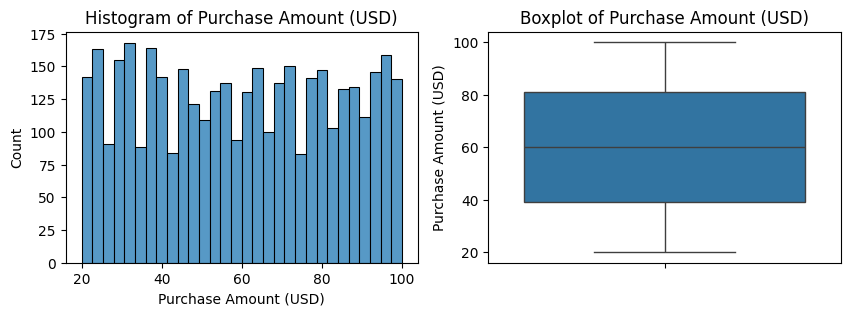

Skewness of Purchase Amount (USD): 0.012701757626433795
Kurtosis of Purchase Amount (USD): -1.236593691266159


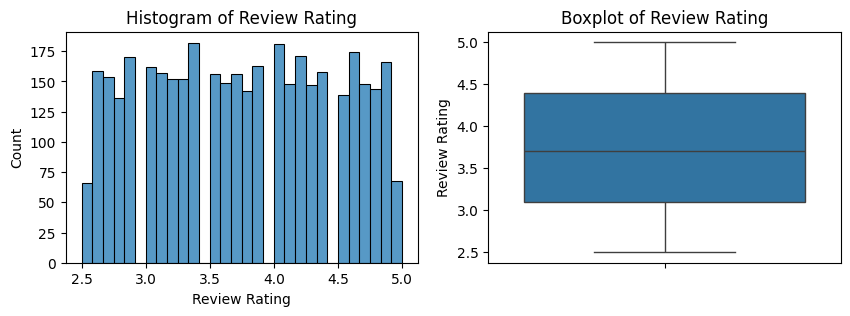

Skewness of Review Rating: 0.00452459644246527
Kurtosis of Review Rating: -1.1796283021299137


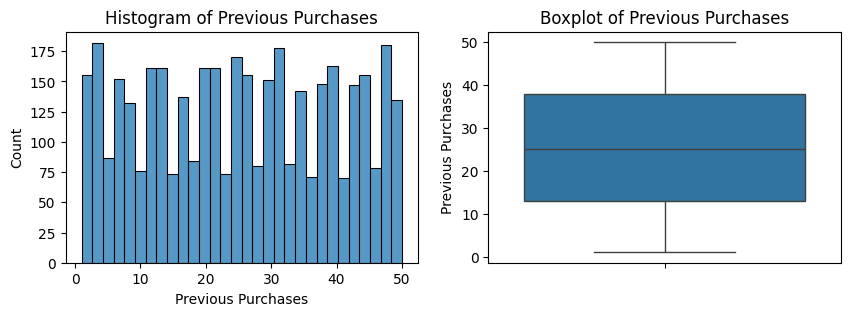

Skewness of Previous Purchases: 0.0031211555127652127
Kurtosis of Previous Purchases: -1.1901873846405375


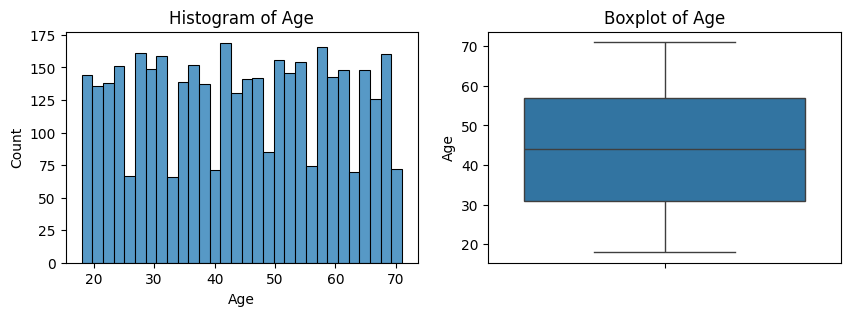

Skewness of Age: -0.00595841926110995
Kurtosis of Age: -1.1934712944349049


In [202]:
# Check the distribution and outliers of numerical columns
def check_distribution(df, columns):
    for i in columns:
        plt.figure(figsize=(10,3))

        # histogram
        plt.subplot(1,2,1)
        sns.histplot(df[i], bins=30)
        plt.title(f'Histogram of {i}')

        # boxplot
        plt.subplot(1,2,2)
        sns.boxplot(y=df[i], data=df)
        plt.title(f'Boxplot of {i}')

        plt.show()

        print(f'Skewness of {i}:', df[i].skew())
        print(f'Kurtosis of {i}:', df[i].kurt())

check_distribution(df[num_cols], num_cols)

There is no outliers in numerical variables. The distribution nearly has uniform distribution

In [203]:
# Descriptive statistic of the numerical variables
df.describe()

,Purchase Amount (USD),Review Rating,Previous Purchases,Age
count,3900.000000,3900.000000,3900.000000,3900.000000
mean,59.764359,3.749949,25.351538,44.113333
std,23.685392,0.716223,14.447125,15.209083
min,20.000000,2.500000,1.000000,18.000000
25%,39.000000,3.100000,13.000000,31.000000
50%,60.000000,3.700000,25.000000,44.000000
75%,81.000000,4.400000,38.000000,57.000000
max,100.000000,5.000000,50.000000,71.000000


In [204]:
# Check the unique values and the count of it from categorical columns
for i in cat_cols:
    print(df[i].value_counts(), "\n")

Gender
Male      2652
Female    1248
Name: count, dtype: int64 

Item Purchased
Blouse        171
Pants         171
Jewelry       171
Shirt         169
Dress         166
Sweater       164
Jacket        163
Coat          161
Sunglasses    161
Belt          161
Sandals       160
Socks         159
Skirt         158
Scarf         157
Shorts        157
Hat           154
Handbag       153
Hoodie        151
Shoes         150
T-shirt       147
Sneakers      145
Boots         144
Backpack      143
Gloves        140
Jeans         124
Name: count, dtype: int64 

Category
Clothing       1737
Accessories    1240
Footwear        599
Outerwear       324
Name: count, dtype: int64 

Size
M     1755
L     1053
S      663
XL     429
Name: count, dtype: int64 

Season
Spring    999
Fall      975
Winter    971
Summer    955
Name: count, dtype: int64 

Subscription Status
No     2847
Yes    1053
Name: count, dtype: int64 

Payment Method
Credit Card      696
Venmo            653
Cash             648
PayPal 

In [205]:
df_first = df.copy()

In [206]:
# Perform label encoding to 
label_enc = LabelEncoder()
label_col = ['Gender', 'Subscription Status', 'Discount Applied', 'Promo Code Used']

df = df.reset_index(drop=True)
for i in label_col:
    df[i] = label_enc.fit_transform(df[[i]].values)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_lab

In [207]:
# Perform Ordinal Encoding to Size and Frequency of Purchases
size_enc = OrdinalEncoder(categories=[['S', 'M', 'L', 'XL']])
df['Size'] = size_enc.fit_transform(df[['Size']])

fop_enc = OrdinalEncoder(categories=[['Weekly', 'Bi-Weekly', 'Monthly', 'Quarterly',  'Annually']])
df['Frequency of Purchases'] = fop_enc.fit_transform(df[['Frequency of Purchases']])

In [208]:
# Perform One-Hot Encoding to Category, Season, Payment Method, Shipping Type, Preferred Payment Method, Item Purchased, Location, Color
oh_enc = OneHotEncoder(sparse_output=False)

oh_category = oh_enc.fit_transform(df[['Category']])
df_category = pd.DataFrame(oh_category, columns=oh_enc.get_feature_names_out(['Category']))
df = pd.concat([df.drop(columns=['Category']), df_category.astype('int')], axis=1)

oh_season = oh_enc.fit_transform(df[['Season']])
df_season = pd.DataFrame(oh_season, columns=oh_enc.get_feature_names_out(['Season']))
df = pd.concat([df.drop(columns=['Season']), df_season.astype('int')], axis=1)

oh_pm = oh_enc.fit_transform(df[['Payment Method']])
df_pm = pd.DataFrame(oh_pm, columns=oh_enc.get_feature_names_out(['Payment Method']))
df = pd.concat([df.drop(columns=['Payment Method']), df_pm.astype('int')], axis=1)

oh_st = oh_enc.fit_transform(df[['Shipping Type']])
df_st = pd.DataFrame(oh_st, columns=oh_enc.get_feature_names_out(['Shipping Type']))
df = pd.concat([df.drop(columns=['Shipping Type']), df_st.astype('int')], axis=1)

oh_ppm = oh_enc.fit_transform(df[['Preferred Payment Method']])
df_ppm = pd.DataFrame(oh_ppm, columns=oh_enc.get_feature_names_out(['Preferred Payment Method']))
df = pd.concat([df.drop(columns=['Preferred Payment Method']), df_ppm.astype('int')], axis=1)

oh_ip = oh_enc.fit_transform(df[['Item Purchased']])
df_ip = pd.DataFrame(oh_ip, columns=oh_enc.get_feature_names_out(['Item Purchased']))
df = pd.concat([df.drop(columns=['Item Purchased']), df_ip.astype('int')], axis=1)

oh_loc = oh_enc.fit_transform(df[['Region']])
df_loc = pd.DataFrame(oh_loc, columns=oh_enc.get_feature_names_out(['Region']))
df = pd.concat([df.drop(columns=['Region']), df_loc.astype('int')], axis=1)

oh_col = oh_enc.fit_transform(df[['Color Category']])
df_col = pd.DataFrame(oh_col, columns=oh_enc.get_feature_names_out(['Color Category']))
df = pd.concat([df.drop(columns=['Color Category']), df_col.astype('int')], axis=1)

In [209]:
# Check the normality of the distribution of the numerical columns
for i in num_cols:
    print(i, shapiro(df[i]))

Purchase Amount (USD) ShapiroResult(statistic=np.float64(0.9502473659114022), pvalue=np.float64(1.8155791638682062e-34))
Review Rating ShapiroResult(statistic=np.float64(0.9555804571242981), pvalue=np.float64(6.499243704155641e-33))
Previous Purchases ShapiroResult(statistic=np.float64(0.9541089689924361), pvalue=np.float64(2.3446933045736986e-33))
Age ShapiroResult(statistic=np.float64(0.9553285905102159), pvalue=np.float64(5.448372898358604e-33))


Beacuse all p-values < 0.05, then all numerical variables are not normally distributed. Hence, Robust Scaler will be used.

In [210]:
# Perform Robust Scaling
rob_scaler = RobustScaler()
rob_col = ['Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 'Age']
df[rob_col] = rob_scaler.fit_transform(df[rob_col])

In [211]:
df = df.reset_index(drop=True)
df.head()

,Gender,Purchase Amount (USD),Size,Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases,Age,...,Item Purchased_Sweater,Item Purchased_T-shirt,Region_MidWest,Region_NorthEast,Region_SouthEast,Region_SouthWest,Region_West,Color Category_Cool,Color Category_Neutral,Color Category_Warm
0,1,-0.166667,2.0,-0.461538,1,1,1,-0.44,1.0,0.423077,...,0,0,0,0,1,0,0,0,1,0
1,1,0.095238,2.0,-0.461538,1,1,1,-0.92,1.0,-0.961538,...,1,0,0,1,0,0,0,0,0,1
2,1,0.309524,0.0,-0.461538,1,1,1,-0.08,0.0,0.230769,...,0,0,0,1,0,0,0,0,0,1
3,1,0.714286,1.0,-0.153846,1,1,1,0.96,0.0,-0.884615,...,0,0,0,1,0,0,0,0,0,1
4,1,-0.261905,1.0,-0.769231,1,1,1,0.24,4.0,0.038462,...,0,0,0,0,0,0,1,1,0,0


### Summary of EDA
- There is 3900 rows of data and 19 columns, with 1 identifier column that then dropped.
- Feature engineering: First, column Age is generated from Birth Date because Age is more meaningful. Second, column Region by dividing Location into 5 regions. Third, column Color Category by dividing color based on its tone.
- There is some replacement in column Gender and Frequency of Purchases because there are some incorrect values and values that has the same meaning.
- There is no missing values and no duplicated rows.
- There is 14 categorical columns and 4 numerical columns. 
- There is no outliers in all numerical variables.
- Binary variables (Gender, Subscription Status, Discount Applied, Promo Code Used) are encode using Label Encoder. 
- Because there is an order (Size and Frequency of Purchases), those variables are encoded using Ordinal Encoder.
- The non-binary categorical variables (Category, Season, Payment Method, Shipping Type, Preferred Payment Method, Item Purchased, Region, Color Category) are encoded using One-Hot Encoder. 
- All numerical variables are not normally distributed.

## B. K-Means Clustering, Fine-tuning, and Clustered Data Visualization 

In [212]:
# Before using PCA
distortions = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=SEED)
    cluster_label=kmeanModel.fit_predict(df)
    #calculate silhouette_score for each cluster
    silhouette_avg = silhouette_score(df, cluster_label)
    print(
        "For n_clusters =", k,
        "The average silhouette_score is :", silhouette_avg,
        )
    #kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center.
    distortions.append(kmeanModel.inertia_)

For n_clusters = 2 The average silhouette_score is : 0.11230548004618883
For n_clusters = 3 The average silhouette_score is : 0.0763706464415732
For n_clusters = 4 The average silhouette_score is : 0.05570232406173539
For n_clusters = 5 The average silhouette_score is : 0.05738861145878429
For n_clusters = 6 The average silhouette_score is : 0.05341718251801767
For n_clusters = 7 The average silhouette_score is : 0.05019496107942669
For n_clusters = 8 The average silhouette_score is : 0.046937909012601094
For n_clusters = 9 The average silhouette_score is : 0.04022806448037737


The silhouette scores are generally low across all values of n_clusters. Scores below 0.15 indicate that the clustering structure is very weak, with overlapping clusters and poor separation. It can happen due to the data has high dimensionality. Hence, I will use PCA to reduce the dimensionality.

### PCA - Dimensionality Reduction

In [213]:
# Perform PCA to the data
pca = PCA()
pca.fit(df)

PCA()

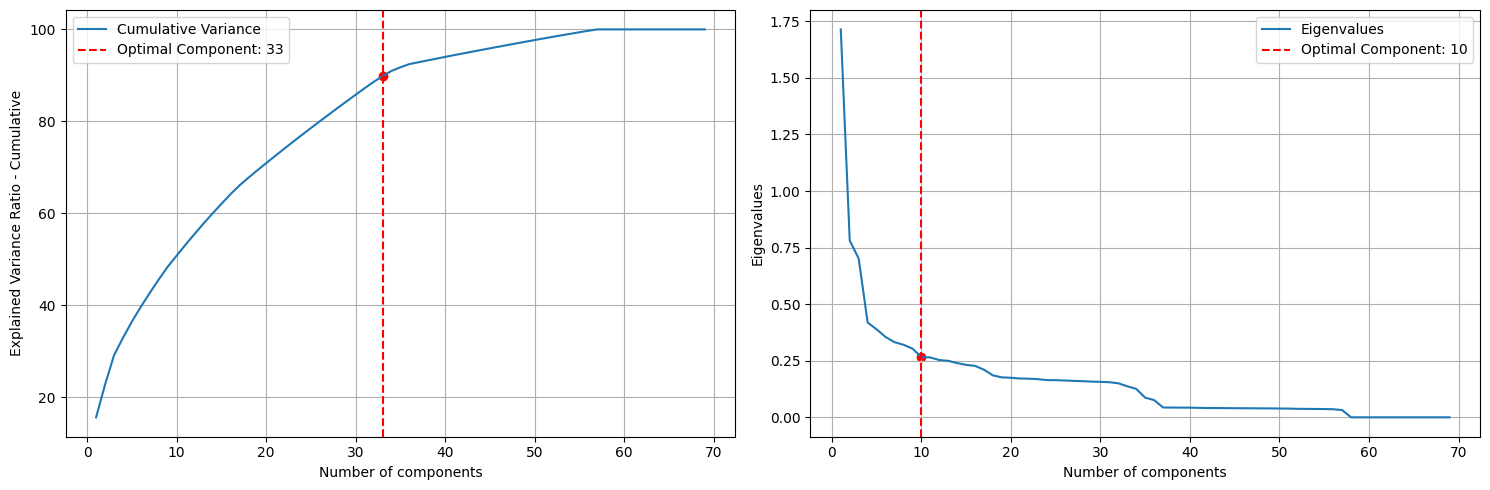

In [214]:
# Search the best n_components
n_components = range(1, len(df.columns) + 1)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_ * 100)
eigenvalues = pca.explained_variance_

# Use KneeLocator to find the best number of components
elbow_variance = KneeLocator(n_components, cumulative_variance, curve="concave", direction="increasing").knee
elbow_eigen = KneeLocator(n_components, eigenvalues, curve="convex", direction="decreasing").knee

# Plot the cumulative explained variance
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(n_components, cumulative_variance, label='Cumulative Variance')
plt.axvline(elbow_variance, color='r', linestyle='--', label=f'Optimal Component: {elbow_variance}')
plt.scatter(elbow_variance, cumulative_variance[elbow_variance - 1], color='red')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cumulative')
plt.legend()

# Plot the eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(n_components, eigenvalues, label='Eigenvalues')
plt.axvline(elbow_eigen, color='r', linestyle='--', label=f'Optimal Component: {elbow_eigen}')
plt.scatter(elbow_eigen, eigenvalues[elbow_eigen - 1], color='red')
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.legend()

plt.tight_layout()
plt.show()

In [215]:
pca_comp = PCA(n_components=10)

df_pca = pca_comp.fit_transform(df)
print(df_pca.shape)
df_pca

(3900, 10)


array([[-1.0462888 ,  0.61782074,  1.136007  , ...,  0.31689456,
        -0.4377182 ,  0.03043135],
       [-1.04675021,  0.60587078,  1.05620672, ...,  0.05482137,
        -0.5177853 ,  0.10853459],
       [-2.03600692, -1.38068597,  0.87482788, ...,  0.29076243,
        -0.32369609,  0.445509  ],
       ...,
       [ 0.96528329,  0.72599114, -0.74638914, ..., -0.49764682,
        -0.21045669,  0.41472523],
       [-2.03729258, -1.18699432, -1.00030721, ...,  0.20406887,
         0.17973728, -1.54322056],
       [ 0.98044912, -0.31365159, -0.85578053, ...,  0.11873781,
        -0.43663392, -0.37322773]])

In [216]:
explained_variance = pca_comp.explained_variance_ratio_.sum()
print(f"Total variance explained by 10 components: {explained_variance * 100:.2f}%")

Total variance explained by 10 components: 50.78%


PCA with n_components = 10 was effective in improving clustering performance by projecting the data into a lower-dimensional space, where clusters are more separable.

Based on the left plot (cumulative variance), the optimal number of components is 33. This point represents the smallest number of components that together explain around 90% of the variance in the data. This indicates that we can retain 33 components to capture most of the information.

Based on the right plot (eigenvalues), the optimal number of components is 10. This point reflects when the eigenvalues start to decrease significantly, meaning that the remaining components explain very little additional variance. Therefore, components with smaller eigenvalues are not as important and can be discarded.

In this case, it is better to keep only the most important components (those with significant eigenvalues), so n_components = 10 is chosen. With n_components = 10, we can already explain a substantial portion of the variance while keeping the dimensionality lower and improving clustering efficiency.

n_clusters = 2 - Silhouette Score: 0.12498578357554499 | Inertia: 19193.186290528123
n_clusters = 3 - Silhouette Score: 0.14493817648752932 | Inertia: 15425.670514708134
n_clusters = 4 - Silhouette Score: 0.1279037354395292 | Inertia: 14184.931718916398
n_clusters = 5 - Silhouette Score: 0.12594536567281733 | Inertia: 13451.669663405248
n_clusters = 6 - Silhouette Score: 0.13434713842318818 | Inertia: 12692.448565127805
n_clusters = 7 - Silhouette Score: 0.12668359563077777 | Inertia: 12087.52814399318
n_clusters = 8 - Silhouette Score: 0.11683477944006826 | Inertia: 11796.688875765989
n_clusters = 9 - Silhouette Score: 0.11829362056639567 | Inertia: 11433.659037258047


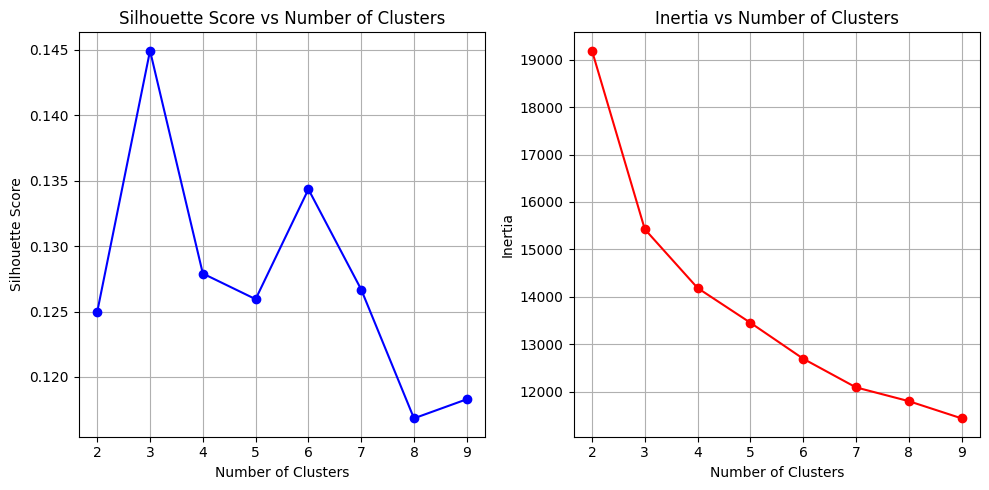

In [217]:
# Fine-tuning the model using Silhouette Score and Inertia (Elbow Method)

# Set a range of clusters to evaluate
K = range(2, 10)

# List to store results
silhouette_scores = []
inertia_scores = []

# Iterate over the range of clusters
for n_clusters in K:
    # Fit KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
    cluster_labels = kmeans.fit_predict(df_pca)  
    
    # Calculate metrics
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    inertia = kmeans.inertia_
    
    # Append metrics
    silhouette_scores.append(silhouette_avg)
    inertia_scores.append(inertia)
    
    # Print the results
    print(f"n_clusters = {n_clusters} - Silhouette Score: {silhouette_avg} | Inertia: {inertia}")

# Plot Silhouette Score vs Number of Clusters
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, silhouette_scores, marker='o', color='blue', label='Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Plot Inertia vs Number of Clusters
plt.subplot(1, 2, 2)
plt.plot(K, inertia_scores, marker='o', color='red', label='Inertia')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)

plt.tight_layout()
plt.show()

The 2 metrics for fine-tuning in this case are Silhouette Score and Inertia. 
1. Silhouette Score -> measures how well each data point fits into its assigned cluster. A higher silhouette score indicates that clusters are well-separated, and the data points are well-matched to their clusters. Higher average silhouette scores suggest better cluster quality. The number of clusters with the highest score is often considered the best.
2. Inertia or within-cluster sum of squares -> measures how spread out the data points are within each cluster. Lower inertia indicates that the clusters are compact and well-formed because it is closer to their cluster centroids.

The goal is to balance inertia with silhouette score to avoid overfitting.
1. The highest Silhouette Score is in n_clusters = 3, which 0.1449 as shown in left plot. While elbow point in right plot is at n_clusters = 3 too. This suggests that n_clusters = 3 could be a reasonable choice, as it balances both cluster compactness and separation better than higher values.

For n_clusters = 2 The average silhouette_score is : 0.12498578357554499
For n_clusters = 3 The average silhouette_score is : 0.14493817648752932
For n_clusters = 4 The average silhouette_score is : 0.1279037354395292
For n_clusters = 5 The average silhouette_score is : 0.12594536567281733
For n_clusters = 6 The average silhouette_score is : 0.13434713842318818
For n_clusters = 7 The average silhouette_score is : 0.12668359563077777
For n_clusters = 8 The average silhouette_score is : 0.11683477944006826
For n_clusters = 9 The average silhouette_score is : 0.11829362056639567


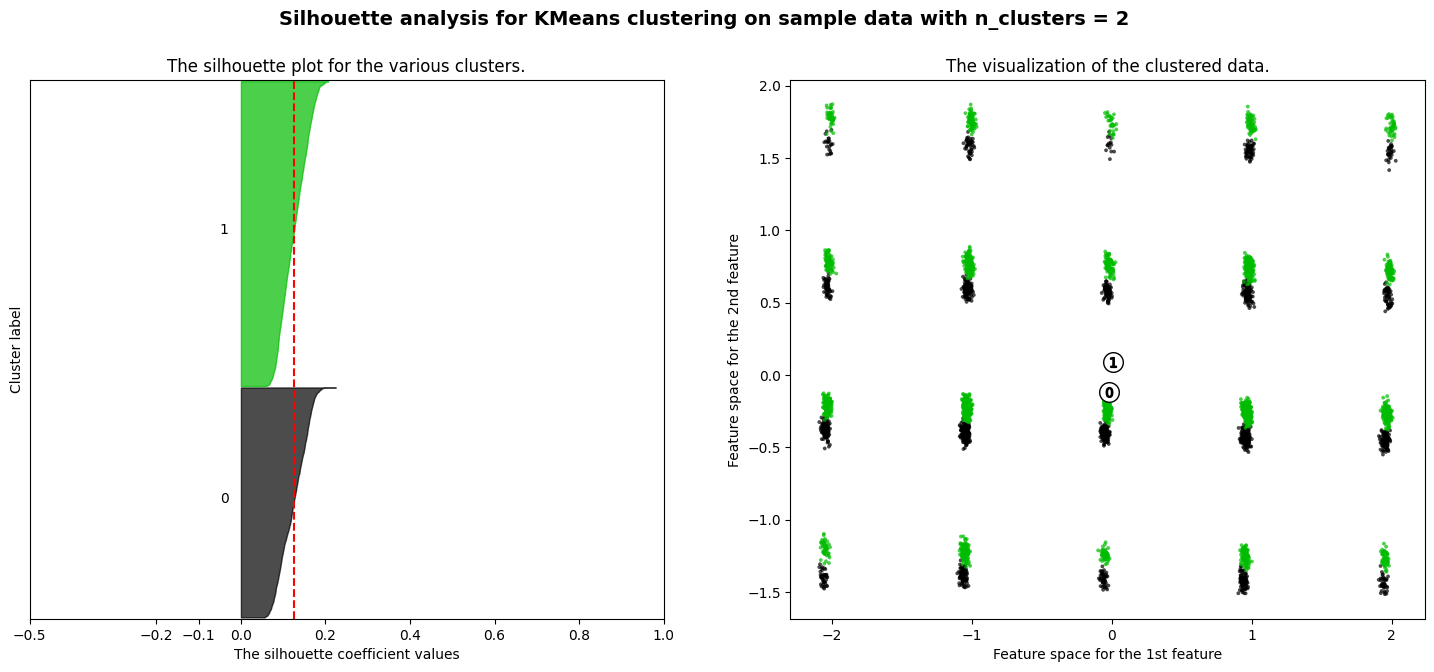

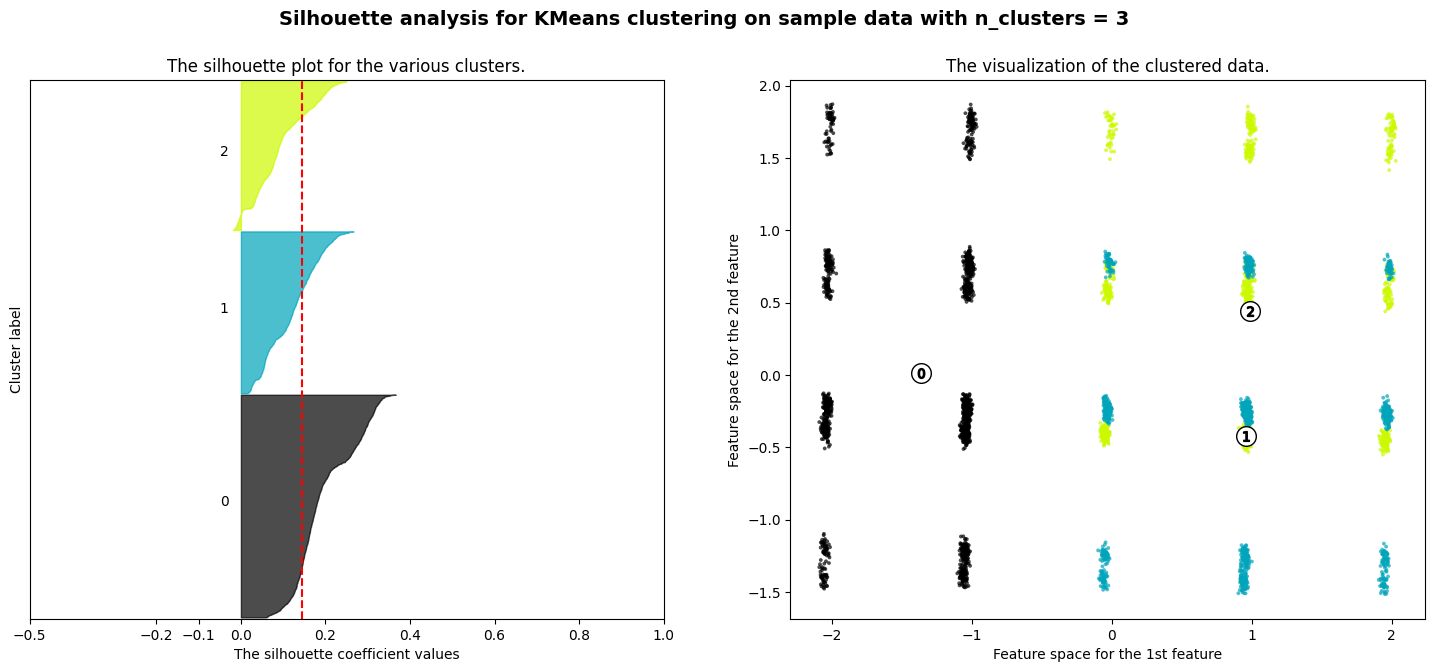

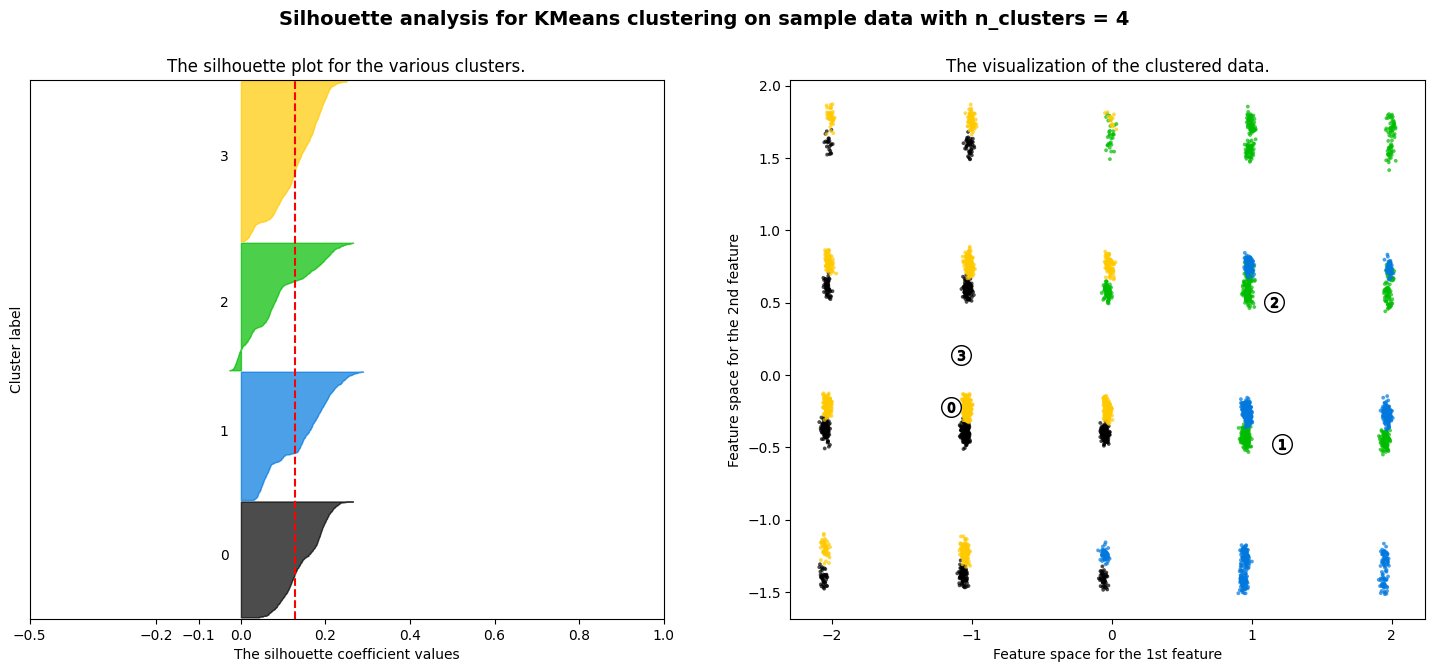

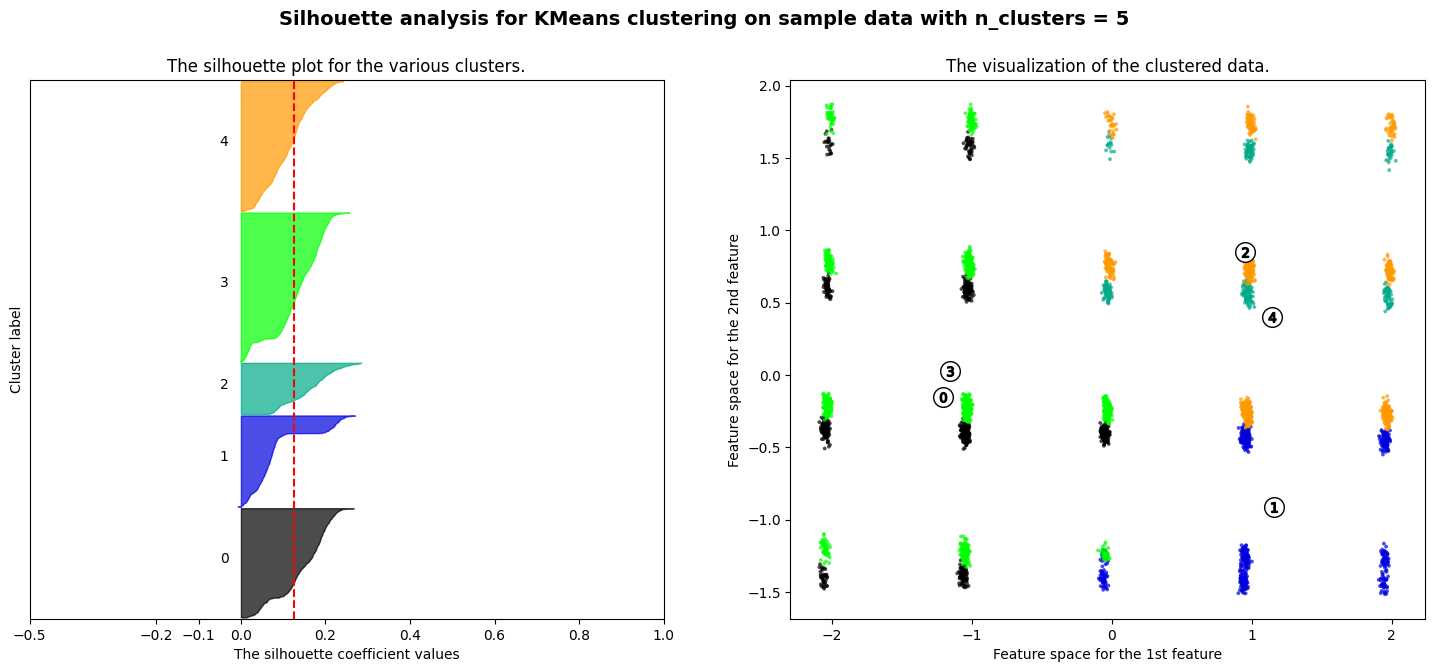

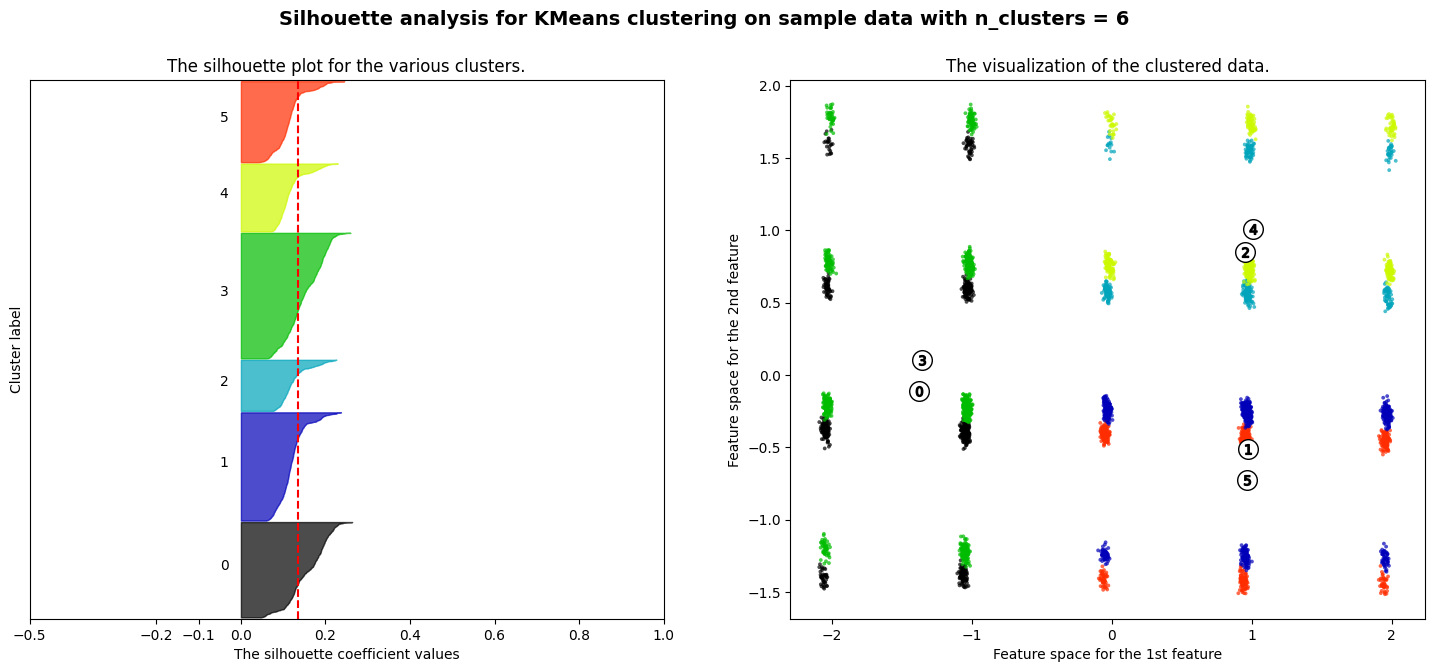

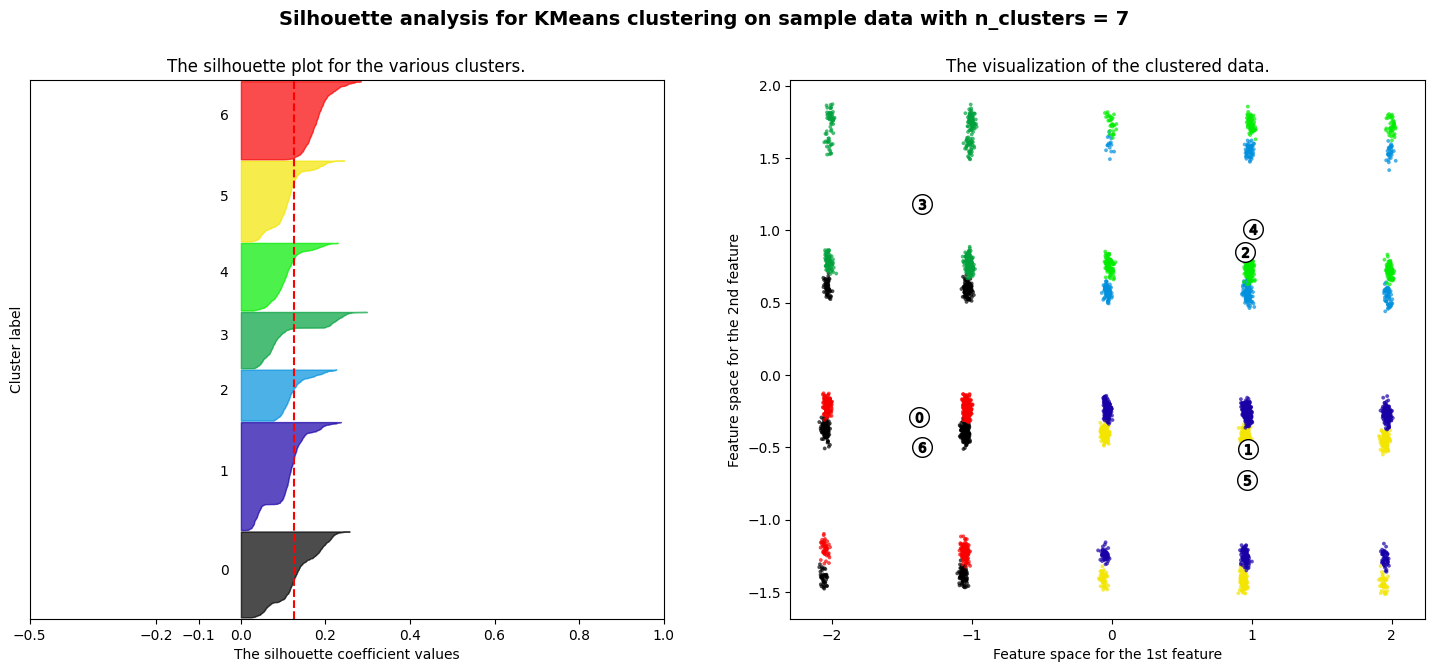

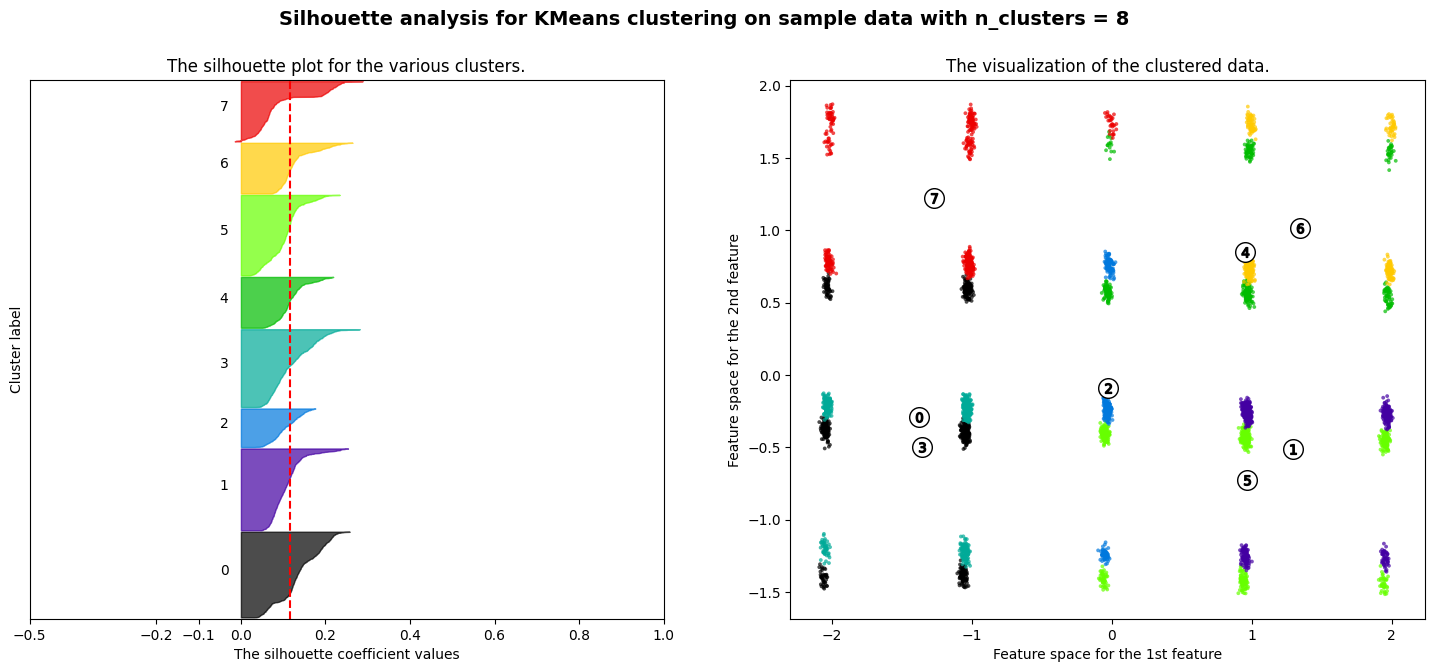

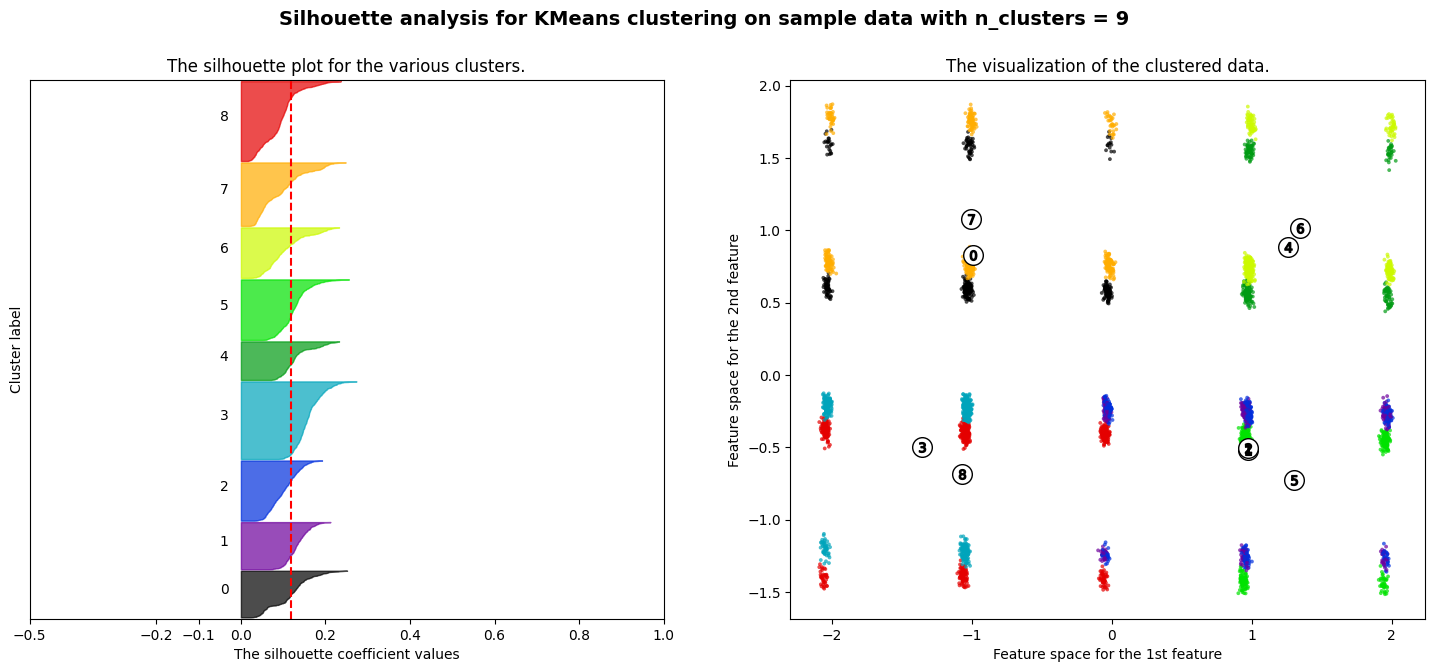

In [218]:
for n_clusters in K:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.5, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_pca) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=SEED)
    cluster_labels = clusterer.fit_predict(df_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.5,-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    pca_comp = PCA(n_components=2)
    df_pca_2 = pca_comp.fit_transform(df)

    ax2.scatter(
        df_pca_2[:, 0], df_pca_2[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [219]:
# Based on silhouette score and elbow method cluster 6 is the best one
kmeanModel = KMeans(n_clusters=3, random_state = SEED)
cluster_pred = kmeanModel.fit_predict(df_pca)
centroids = kmeans.cluster_centers_ 

df_kmeans = df.copy()
df_kmeans['cluster'] = cluster_pred
df_kmeans

,Gender,Purchase Amount (USD),Size,Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases,Age,...,Item Purchased_T-shirt,Region_MidWest,Region_NorthEast,Region_SouthEast,Region_SouthWest,Region_West,Color Category_Cool,Color Category_Neutral,Color Category_Warm,cluster
0,1,-0.166667,2.0,-0.461538,1,1,1,-0.44,1.0,0.423077,...,0,0,0,1,0,0,0,1,0,0
1,1,0.095238,2.0,-0.461538,1,1,1,-0.92,1.0,-0.961538,...,0,0,1,0,0,0,0,0,1,0
2,1,0.309524,0.0,-0.461538,1,1,1,-0.08,0.0,0.230769,...,0,0,1,0,0,0,0,0,1,0
3,1,0.714286,1.0,-0.153846,1,1,1,0.96,0.0,-0.884615,...,0,0,1,0,0,0,0,0,1,0
4,1,-0.261905,1.0,-0.769231,1,1,1,0.24,4.0,0.038462,...,0,0,0,0,0,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,0,-0.761905,2.0,0.384615,0,0,0,0.28,0.0,-0.153846,...,0,0,0,1,0,0,1,0,0,0
3896,0,-0.261905,2.0,0.615385,0,0,0,0.64,1.0,0.307692,...,0,1,0,0,0,0,0,1,0,0
3897,0,-0.642857,2.0,-0.615385,0,0,0,-0.04,3.0,0.076923,...,0,0,1,0,0,0,1,0,0,1
3898,0,0.404762,0.0,0.076923,0,0,0,-0.04,0.0,0.000000,...,0,1,0,0,0,0,0,1,0,0


In [220]:
df_kmeans['cluster'].value_counts()

cluster
0    1628
1    1184
2    1088
Name: count, dtype: int64

From the K-Means model, cluster 0 has 1628 data, cluster 1 has 1184 data, and cluster 2 has 1088 data.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14712\3624309190.py:12: RuntimeWarning: Mean of empty slice.
  centroid_x = X_tsne[df_kmeans['cluster'] == i, 0].mean()
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14712\3624309190.py:13: RuntimeWarning: Mean of empty slice.
  centroid_y = X_tsne[df_kmeans['cluster'] == i, 1].mean()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


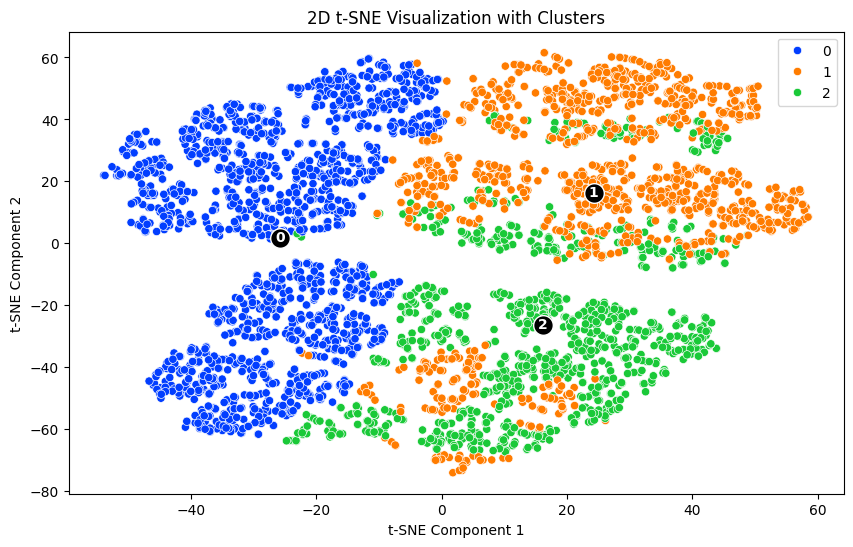

In [221]:
# Visualization using TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_pca)

# Plot t-SNE result with cluster labels as colors
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df_kmeans['cluster'], palette='bright')

# Loop through each cluster and plot the centroids with text
for i in range(6):  # Assuming 6 clusters
    # Get the mean position of the cluster points in the t-SNE space
    centroid_x = X_tsne[df_kmeans['cluster'] == i, 0].mean()
    centroid_y = X_tsne[df_kmeans['cluster'] == i, 1].mean()
    
    # Plot the centroid
    plt.scatter(centroid_x, centroid_y, color='black', s=200, marker='o', edgecolors='white')
    
    # Add the cluster label at the centroid
    plt.text(centroid_x, centroid_y, f'{i}', color='white', ha='center', va='center', fontweight='bold')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D t-SNE Visualization with Clusters')
plt.legend()
plt.show()

From the visualization above, cluster 1 and 2 show some overlap, which suggests that the features used in the clustering process may not be sufficiently distinct for these two groups.

## C. Cluster Analysis

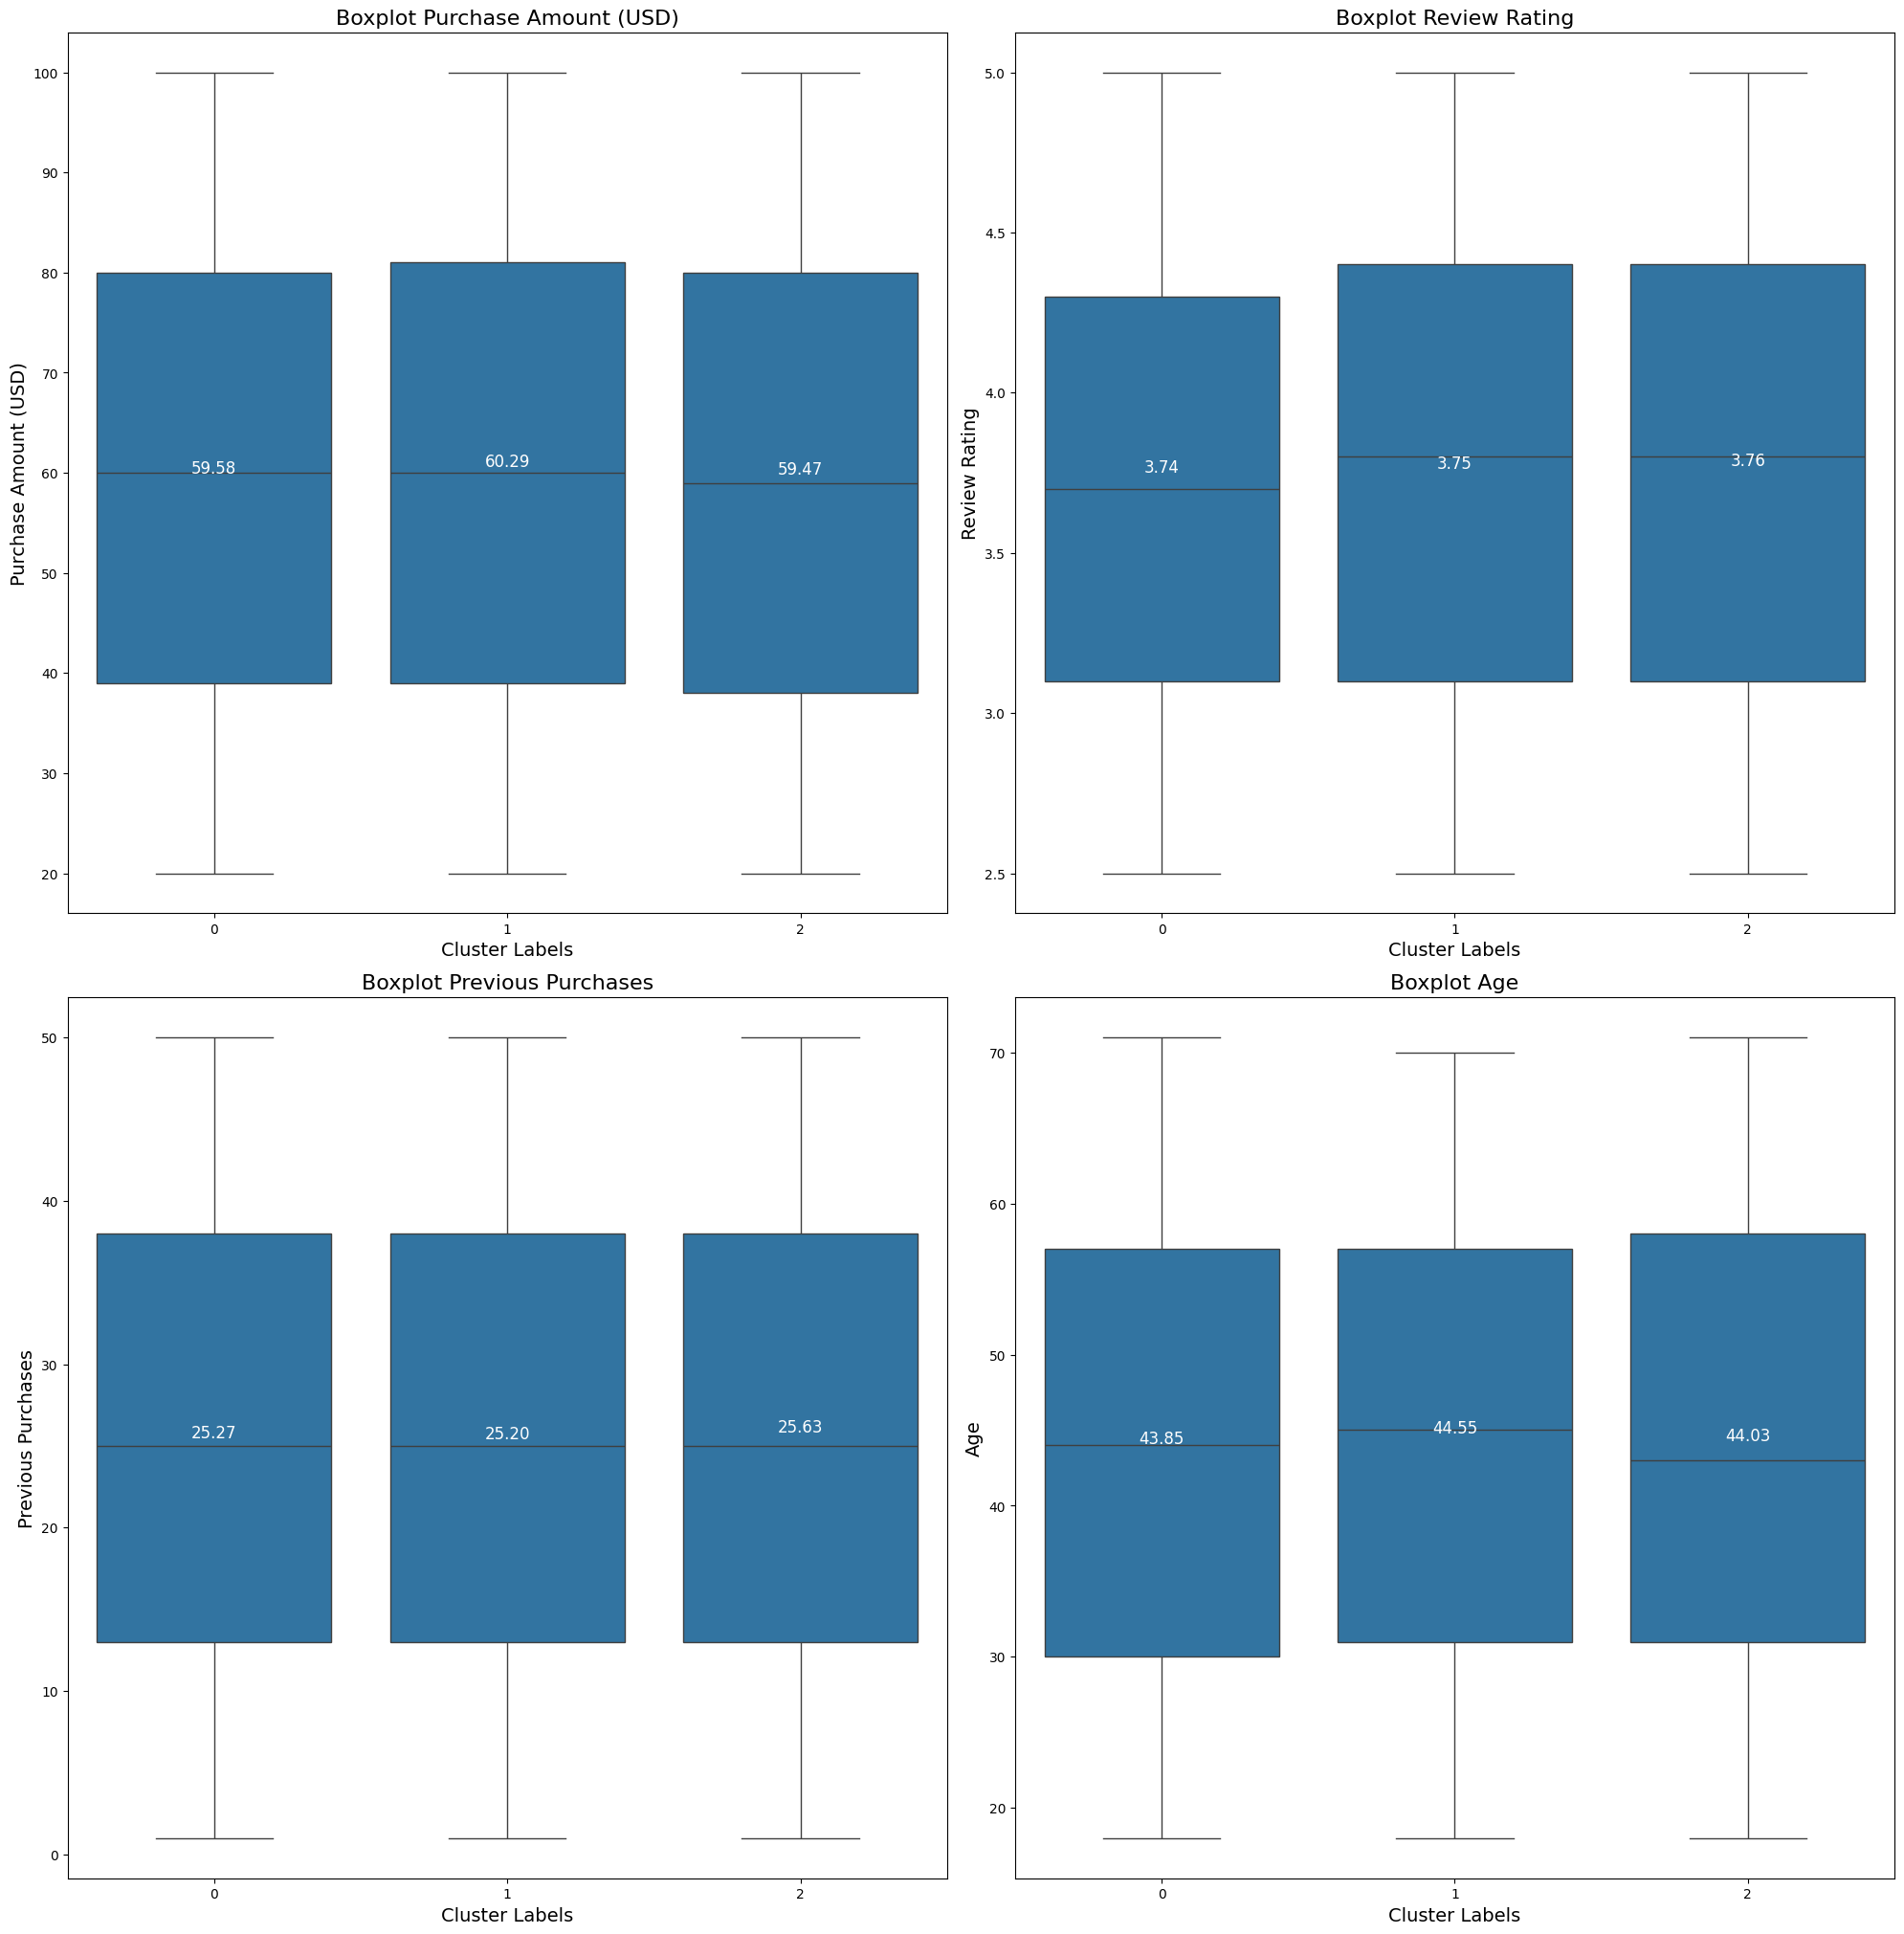

In [222]:
# Inverse the transformation for each numerical variables
medians = rob_scaler.center_
iqrs = rob_scaler.scale_

for i, fitur in enumerate(num_cols):
    df_kmeans[fitur] = df_kmeans[fitur] * iqrs[i] + medians[i]

# Now, you can plot the boxplots with the original scale (after inversion)
plt.figure(figsize=(20, 40))
for i, fitur in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 2, i)
    sns.boxplot(x='cluster', y=fitur, data=df_kmeans, showfliers=False)
    plt.xlabel('Cluster Labels', fontsize=14)
    plt.ylabel(fitur, fontsize=14)
    plt.title(f'Boxplot {fitur}', fontsize=16)
    
    # Adding mean values on the boxplot
    means = df_kmeans.groupby('cluster')[fitur].mean().values
    for j, mean in enumerate(means):
        plt.text(j, mean, f'{mean:.2f}', ha='center', va='bottom', color='white', fontsize=12)

plt.tight_layout()
plt.show()

Characteristics of the Cluster Based On Numerical Variables
1. The purchase amount is almost identical across the three clusters , with very little variation. This implies that the average of all clusters is nearly the same, which around 60 USD.
2. Ratings are very close across the three clusters, with only a minimal increase from Cluster 0 to Cluster 2. This could imply that all clusters have similar overall satisfaction or evaluation scores, which around 3.75.
2. The number of previous purchases is very similar across the clusters, which 25.
4. The age distribution across the clusters is also quite close (around 43-44), with a slight increase in age from Cluster 0 to Cluster 1.

In [223]:
# Inverse transform for binary encoding
label_columns = ['Subscription Status', 'Discount Applied', 'Promo Code Used']

for col in label_columns:
    df_kmeans[col] = label_enc.inverse_transform(df_kmeans[col])

In [224]:
# Inverse transform for ordinal encoding
gender_mapping = {1: 'Male', 0: 'Female'}
df_kmeans['Gender'] = df_kmeans['Gender'].map(gender_mapping)

size_mapping = {0: 'S', 1: 'M', 2: 'L', 3: 'XL'}
df_kmeans['Size'] = df_kmeans['Size'].map(size_mapping)

fop_mapping = {0: 'Weekly', 1: 'Bi-Weekly', 2: 'Monthly', 3: 'Quarterly', 4: 'Annually'} 
df_kmeans['Frequency of Purchases'] = df_kmeans['Frequency of Purchases'].map(fop_mapping)

In [225]:
# Inverse transform for one hot encoding
one_hot_columns = [
    'Category_Accessories', 'Category_Clothing', 'Category_Footwear',
    'Category_Outerwear', 'Season_Fall', 'Season_Spring', 'Season_Summer',
    'Season_Winter', 'Payment Method_Bank Transfer', 'Payment Method_Cash',
    'Payment Method_Credit Card', 'Payment Method_Debit Card',
    'Payment Method_PayPal', 'Payment Method_Venmo',
    'Shipping Type_2-Day Shipping', 'Shipping Type_Express',
    'Shipping Type_Free Shipping', 'Shipping Type_Next Day Air',
    'Shipping Type_Standard', 'Shipping Type_Store Pickup',
    'Preferred Payment Method_Bank Transfer',
    'Preferred Payment Method_Cash', 'Preferred Payment Method_Credit Card',
    'Preferred Payment Method_Debit Card',
    'Preferred Payment Method_PayPal', 'Preferred Payment Method_Venmo',
    'Item Purchased_Backpack', 'Item Purchased_Belt',
    'Item Purchased_Blouse', 'Item Purchased_Boots', 'Item Purchased_Coat',
    'Item Purchased_Dress', 'Item Purchased_Gloves',
    'Item Purchased_Handbag', 'Item Purchased_Hat', 'Item Purchased_Hoodie',
    'Item Purchased_Jacket', 'Item Purchased_Jeans',
    'Item Purchased_Jewelry', 'Item Purchased_Pants',
    'Item Purchased_Sandals', 'Item Purchased_Scarf',
    'Item Purchased_Shirt', 'Item Purchased_Shoes', 'Item Purchased_Shorts',
    'Item Purchased_Skirt', 'Item Purchased_Sneakers',
    'Item Purchased_Socks', 'Item Purchased_Sunglasses',
    'Item Purchased_Sweater', 'Item Purchased_T-shirt', 'Region_MidWest',
    'Region_NorthEast', 'Region_SouthEast', 'Region_SouthWest',
    'Region_West', 'Color Category_Cool', 'Color Category_Neutral',
    'Color Category_Warm'
]

df_kmeans['Category'] = df_kmeans[['Category_Accessories', 'Category_Clothing', 'Category_Footwear', 'Category_Outerwear']].idxmax(axis=1).str.replace('Category_', '')
df_kmeans['Season'] = df_kmeans[['Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter']].idxmax(axis=1).str.replace('Season_', '')
df_kmeans['Payment Method'] = df_kmeans[['Payment Method_Bank Transfer', 'Payment Method_Cash', 'Payment Method_Credit Card',
                                        'Payment Method_Debit Card', 'Payment Method_PayPal', 'Payment Method_Venmo']].idxmax(axis=1).str.replace('Payment Method_', '')
df_kmeans['Shipping Type'] = df_kmeans[['Shipping Type_2-Day Shipping', 'Shipping Type_Express', 'Shipping Type_Free Shipping', 
                                        'Shipping Type_Next Day Air', 'Shipping Type_Standard', 'Shipping Type_Store Pickup']].idxmax(axis=1).str.replace('Shipping Type_', '')
df_kmeans['Preferred Payment Method'] = df_kmeans[['Preferred Payment Method_Bank Transfer', 'Preferred Payment Method_Cash', 
                                                'Preferred Payment Method_Credit Card', 'Preferred Payment Method_Debit Card',
                                                'Preferred Payment Method_PayPal', 'Preferred Payment Method_Venmo']].idxmax(axis=1).str.replace('Preferred Payment Method_', '')
df_kmeans['Item Purchased'] = df_kmeans[[
    'Item Purchased_Backpack', 'Item Purchased_Belt',
    'Item Purchased_Blouse', 'Item Purchased_Boots', 'Item Purchased_Coat',
    'Item Purchased_Dress', 'Item Purchased_Gloves',
    'Item Purchased_Handbag', 'Item Purchased_Hat', 'Item Purchased_Hoodie',
    'Item Purchased_Jacket', 'Item Purchased_Jeans',
    'Item Purchased_Jewelry', 'Item Purchased_Pants',
    'Item Purchased_Sandals', 'Item Purchased_Scarf',
    'Item Purchased_Shirt', 'Item Purchased_Shoes', 'Item Purchased_Shorts',
    'Item Purchased_Skirt', 'Item Purchased_Sneakers',
    'Item Purchased_Socks', 'Item Purchased_Sunglasses',
    'Item Purchased_Sweater', 'Item Purchased_T-shirt'
]].idxmax(axis=1).str.replace('Item Purchased_', '')
df_kmeans['Region'] = df_kmeans[['Region_MidWest', 'Region_NorthEast', 'Region_SouthEast', 'Region_SouthWest', 'Region_West']].idxmax(axis=1).str.replace('Region_', '')
df_kmeans['Color Category'] = df_kmeans[['Color Category_Cool', 'Color Category_Neutral', 'Color Category_Warm']].idxmax(axis=1).str.replace('Color Category_', '')

# Drop the one-hot encoded columns
df_kmeans.drop(columns=one_hot_columns, axis=1, inplace=True)
df_kmeans.reset_index(drop=True, inplace=True)


In [226]:
df_kmeans

,Gender,Purchase Amount (USD),Size,Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases,Age,cluster,Category,Season,Payment Method,Shipping Type,Preferred Payment Method,Item Purchased,Region,Color Category
0,Male,53.0,L,3.1,Yes,Yes,Yes,14.0,Bi-Weekly,55.0,0,Clothing,Winter,Credit Card,Express,Venmo,Blouse,SouthEast,Neutral
1,Male,64.0,L,3.1,Yes,Yes,Yes,2.0,Bi-Weekly,19.0,0,Clothing,Winter,Bank Transfer,Express,Cash,Sweater,NorthEast,Warm
2,Male,73.0,S,3.1,Yes,Yes,Yes,23.0,Weekly,50.0,0,Clothing,Spring,Cash,Free Shipping,Credit Card,Jeans,NorthEast,Warm
3,Male,90.0,M,3.5,Yes,Yes,Yes,49.0,Weekly,21.0,0,Footwear,Spring,PayPal,Next Day Air,PayPal,Sandals,NorthEast,Warm
4,Male,49.0,M,2.7,Yes,Yes,Yes,31.0,Annually,45.0,2,Clothing,Spring,Cash,Free Shipping,PayPal,Blouse,West,Cool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,Female,28.0,L,4.2,No,No,No,32.0,Weekly,40.0,0,Clothing,Summer,Cash,2-Day Shipping,Venmo,Hoodie,SouthEast,Cool
3896,Female,49.0,L,4.5,No,No,No,41.0,Bi-Weekly,52.0,0,Accessories,Spring,PayPal,Store Pickup,Bank Transfer,Backpack,MidWest,Neutral
3897,Female,33.0,L,2.9,No,No,No,24.0,Quarterly,46.0,1,Accessories,Spring,Credit Card,Standard,Venmo,Belt,NorthEast,Cool
3898,Female,77.0,S,3.8,No,No,No,24.0,Weekly,44.0,0,Footwear,Summer,PayPal,Express,Venmo,Shoes,MidWest,Neutral


In [230]:
# Mode of categorical variables
categorical_columns = ['Gender', 'Subscription Status', 'Discount Applied', 'Promo Code Used', 'Size', 
                    'Category', 'Season', 'Payment Method', 'Shipping Type', 'Preferred Payment Method', 
                    'Item Purchased', 'Region', 'Color Category']

# Group by 'cluster' and apply mode on each categorical column
mode_values = df_kmeans.groupby('cluster')[categorical_columns].apply(lambda x: x.mode(axis=0, dropna=True).iloc[0])
mode_values

,Gender,Subscription Status,Discount Applied,Promo Code Used,Size,Category,Season,Payment Method,Shipping Type,Preferred Payment Method,Item Purchased,Region,Color Category
cluster,,,,,,,,,,,,,
0,Male,No,No,No,M,Clothing,Spring,Credit Card,Standard,Cash,Sweater,SouthEast,Cool
1,Female,No,No,No,M,Clothing,Fall,Credit Card,Free Shipping,PayPal,Blouse,SouthEast,Cool
2,Male,No,Yes,Yes,L,Clothing,Summer,Cash,Next Day Air,Credit Card,Shirt,MidWest,Cool


Characteristics in Each Cluster Based On Categorical Variables
1. Cluster 0 and Cluster 1 are somewhat similar. Both clusters do not use discounts or promo codes. Both clusters primarily use credit cards for payments. Customers in these clusters purchase medium-sized clothing. Both clusters are primarily located in the SouthEast region. 
2. Cluster 2 shows more distinct behaviors, including using discounts and promo codes, preferring faster shipping (next day air), and purchasing larger-sized clothing. This cluster also stands out for its preference for cash payments despite using credit cards. Most of cluster 2 are from MidWest
3. The clusters differ significantly in the type of clothing item purchased, with sweaters in Cluster 0, blouses in Cluster 1, and shirts in Cluster 2. Besdies that, Cluster 0 prefers spring, Cluster 1 favors fall, and Cluster 2 opts for summer, highlighting the seasonal variation in purchasing behavior. The clusters also have distinct shipping preferences: Cluster 0 chooses standard shipping, Cluster 1 selects free shipping, and Cluster 2 prioritizes next day air, indicating different levels of urgency or value placed on delivery speed.
4. All three clusters prefer cool colors for their clothing, suggesting a shared aesthetic preference across customer segments.